<a href="https://colab.research.google.com/github/htsnet/automacao-de-negocios/blob/master/AutomacaoNegocios_SegundaIdeia_Arvores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Uma avaliação da segunda ideia usando apenas árvores de decisão e similares

# Início: Importação as bibliotecas e Arquivo
É preciso carregar um arquivo CSV com o padrão definido para execução do notebook

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from matplotlib.pyplot import figure
import datetime
import pickle
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
import seaborn as sns
from numpy.random import seed

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#define um SEED para o processo de forma a ter resultados comparáveis
seed(1)

In [3]:
#informa os critérios deste modelo
ganho = 1
perda = 0

In [4]:
#carrega a tabela de dados
#separador de campos = ;
#ponto decimal = ,
historic = pd.read_csv("/content/MAI - JUN - JUL - TTO v2 10h15 em diante - Final.csv", sep=";", decimal=",")

In [5]:
historic.shape

(77393, 26)

In [6]:
#remove campos desnecessários
tabelaAjustada = historic.drop(['Data', 'Hora'], axis=1)
tabelaAjustada = tabelaAjustada.iloc[:,0:7]
tabelaAjustada.head()

,DOLAR,ÍNDICE,VALE3,ITUB4,CMIG4,LAME4,Dolar_Target_5m
0,-47.36,88.39,18.28,-4.56,-10.93,0.0,1
1,-47.36,91.56,11.43,4.56,-10.93,0.0,1
2,-44.67,90.29,4.58,-4.56,0.00,0.0,1
3,-43.77,90.93,27.39,-32.04,-10.93,0.0,1
4,-43.77,87.75,29.67,-22.86,0.00,0.0,1


# Criando um arquivo para treino e outro para teste

In [7]:
#separa as features do target
X = tabelaAjustada.iloc[:,0:6]
y = tabelaAjustada.iloc[:,6:]
print(X.describe, y.describe)

<bound method NDFrame.describe of        DOLAR  ÍNDICE  VALE3   ITUB4   CMIG4   LAME4
0     -47.36   88.39  18.28   -4.56  -10.93    0.00
1     -47.36   91.56  11.43    4.56  -10.93    0.00
2     -44.67   90.29   4.58   -4.56    0.00    0.00
3     -43.77   90.93  27.39  -32.04  -10.93    0.00
4     -43.77   87.75  29.67  -22.86    0.00    0.00
...      ...     ...    ...     ...     ...     ...
77388  66.97 -233.89 -60.93 -340.36 -149.13 -310.85
77389  71.72 -233.89 -55.96 -332.72 -182.88 -307.83
77390  70.77 -233.89 -64.24 -332.72 -182.88 -307.83
77391  67.92 -233.89 -54.30 -332.72 -182.88 -292.74
77392  71.72 -233.89 -65.90 -328.90 -182.88 -292.74

[77393 rows x 6 columns]> <bound method NDFrame.describe of        Dolar_Target_5m
0                    1
1                    1
2                    1
3                    1
4                    1
...                ...
77388                1
77389                1
77390                1
77391                1
77392                1

[773

In [8]:
# Separando uma parte para treino (90%) e outra para validação (10%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state=9)
print('Qtde de treino: {}'.format(len(X_train)))
print('Qtde de validação: {}'.format(len(y_test)))

Qtde de treino: 69653
Qtde de validação: 7740


# Modelagem

In [9]:
#definição de parâmetros para todos os classificadores
estimadores = 200
quantidadeValidacaoCruzada = 30

In [10]:
#define a apresentação dos resultados das modelagens
def mostraResultado(y_test, valoresPrevistos):
  #lista quantidade de acertos
  contaOk = 0
  contaNao = 0
  contaDesconsiderados = 0
  for i in range(0, len(y_test)):
    if valoresPrevistos[i] == ganho  and y_test[i] == ganho:
      contaOk += 1
    elif valoresPrevistos[i] == ganho  and y_test[i] == perda:
      contaNao += 1
    else:
      contaDesconsiderados += 1

  print("Quantidade de resultados OK (1 = 1): {}\nQuantidade de resultados Não (1 = 0): {}".format(contaOk, contaNao))
  print("Percentual de acertos: {:.1f}%".format(contaOk/(contaOk+contaNao)*100))
  print("Quantidade de resultados desconsiderados: {}".format(contaDesconsiderados))

In [11]:
#faz a função para gerar modelo 1
def rfc_test(X_train, y_train, n_estimators, cv):
  np.random.seed(1)
  rfc = RandomForestClassifier(n_estimators=n_estimators, random_state=0, n_jobs=-1, criterion='entropy', verbose=0)
  cv_scores = cross_val_score(rfc, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
  print('Média dos {} testes: '.format(cv), cv_scores.mean())
  return rfc

In [12]:
#gera o modelo
model = rfc_test(X_train, y_train, cv=quantidadeValidacaoCruzada, n_estimators=estimadores)

Média dos 30 testes:  0.9278988092454632


In [13]:
#fit modelo
model.fit(X_train, y_train.values.ravel())

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [14]:
#salva o modelo para uso posterior em outro notebook em produção
arquivo_modelo = 'modeloSI_RF.pkl'
pickle.dump(model, open(arquivo_modelo, 'wb'))

In [15]:
#faz predição com dados de validacao
valoresPrevistos = model.predict(X_test)

In [16]:
y_test.values.ravel()


array([0, 0, 0, ..., 1, 1, 0])

In [17]:
valoresPrevistos

array([0, 0, 0, ..., 1, 1, 0])

In [18]:
#resultado = 0 ou 1
mostraResultado(y_test.values.ravel(), valoresPrevistos)

Quantidade de resultados OK (1 = 1): 3280
Quantidade de resultados Não (1 = 0): 544
Percentual de acertos: 85.8%
Quantidade de resultados desconsiderados: 3916


Text(0.5, 15.0, 'Previsão')

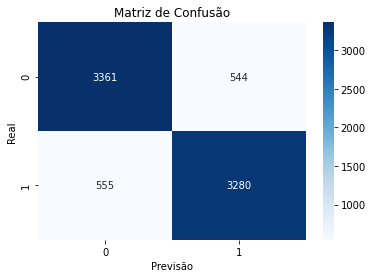

In [19]:
#gera uma matriz de confusão
cm = confusion_matrix(y_test, valoresPrevistos)
x_axis_labels = [0, 1]
y_axis_labels = [0, 1]
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.title('Matriz de Confusão')
plt.ylabel('Real')
plt.xlabel('Previsão')


In [20]:
#faz a função para gerar modelo 2
def abc_test(X_train, y_train, n_estimators, cv):
  np.random.seed(1)
  abc = AdaBoostClassifier(random_state=2, n_estimators=n_estimators, algorithm='SAMME') 
  cv_scores = cross_val_score(abc, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
  print('Média dos {} testes: '.format(cv), cv_scores.mean())
  return abc

In [21]:
#gera o modelo
model = abc_test(X_train, y_train, cv=quantidadeValidacaoCruzada, n_estimators=estimadores)

Média dos 30 testes:  0.5501251426566837


In [22]:
#fit modelo
model.fit(X_train, y_train.values.ravel())

AdaBoostClassifier(algorithm='SAMME', base_estimator=None, learning_rate=1.0,
                   n_estimators=200, random_state=2)

In [23]:
#salva o modelo para uso posterior em outro notebook em produção
arquivo_modelo = 'modeloSI_AB.pkl'
pickle.dump(model, open(arquivo_modelo, 'wb'))

In [24]:
#faz predição com dados de validacao
valoresPrevistos = model.predict(X_test)
#resultado = 1 ou 2
mostraResultado(y_test.values.ravel(), valoresPrevistos)

Quantidade de resultados OK (1 = 1): 1692
Quantidade de resultados Não (1 = 0): 1466
Percentual de acertos: 53.6%
Quantidade de resultados desconsiderados: 4582


In [25]:
#faz a função para gerar modelo 3
def gbc_test(X_train, y_train, n_estimators, cv):
  np.random.seed(1)
  gbc = GradientBoostingClassifier(random_state=2, n_estimators=n_estimators) 
  cv_scores = cross_val_score(gbc, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
  print('Média dos {} testes: '.format(cv), cv_scores.mean())
  return gbc

In [26]:
#gera o modelo
model = gbc_test(X_train, y_train, cv=quantidadeValidacaoCruzada, n_estimators=estimadores)

Média dos 30 testes:  0.6478771095849244


In [27]:
#fit modelo
model.fit(X_train, y_train.values.ravel())

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=2, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [28]:
#salva o modelo para uso posterior em outro notebook em produção
arquivo_modelo = 'modeloSI_GB.pkl'
pickle.dump(model, open(arquivo_modelo, 'wb'))

In [29]:
#faz predição com dados de validacao
valoresPrevistos = model.predict(X_test)
#resultado = 1 ou 2
mostraResultado(y_test.values.ravel(), valoresPrevistos)

Quantidade de resultados OK (1 = 1): 2062
Quantidade de resultados Não (1 = 0): 1344
Percentual de acertos: 60.5%
Quantidade de resultados desconsiderados: 4334
